c:\Users\asusg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The size of the dataset before transformations: 4829 images
The size of the dataset after transformations: 4829 images


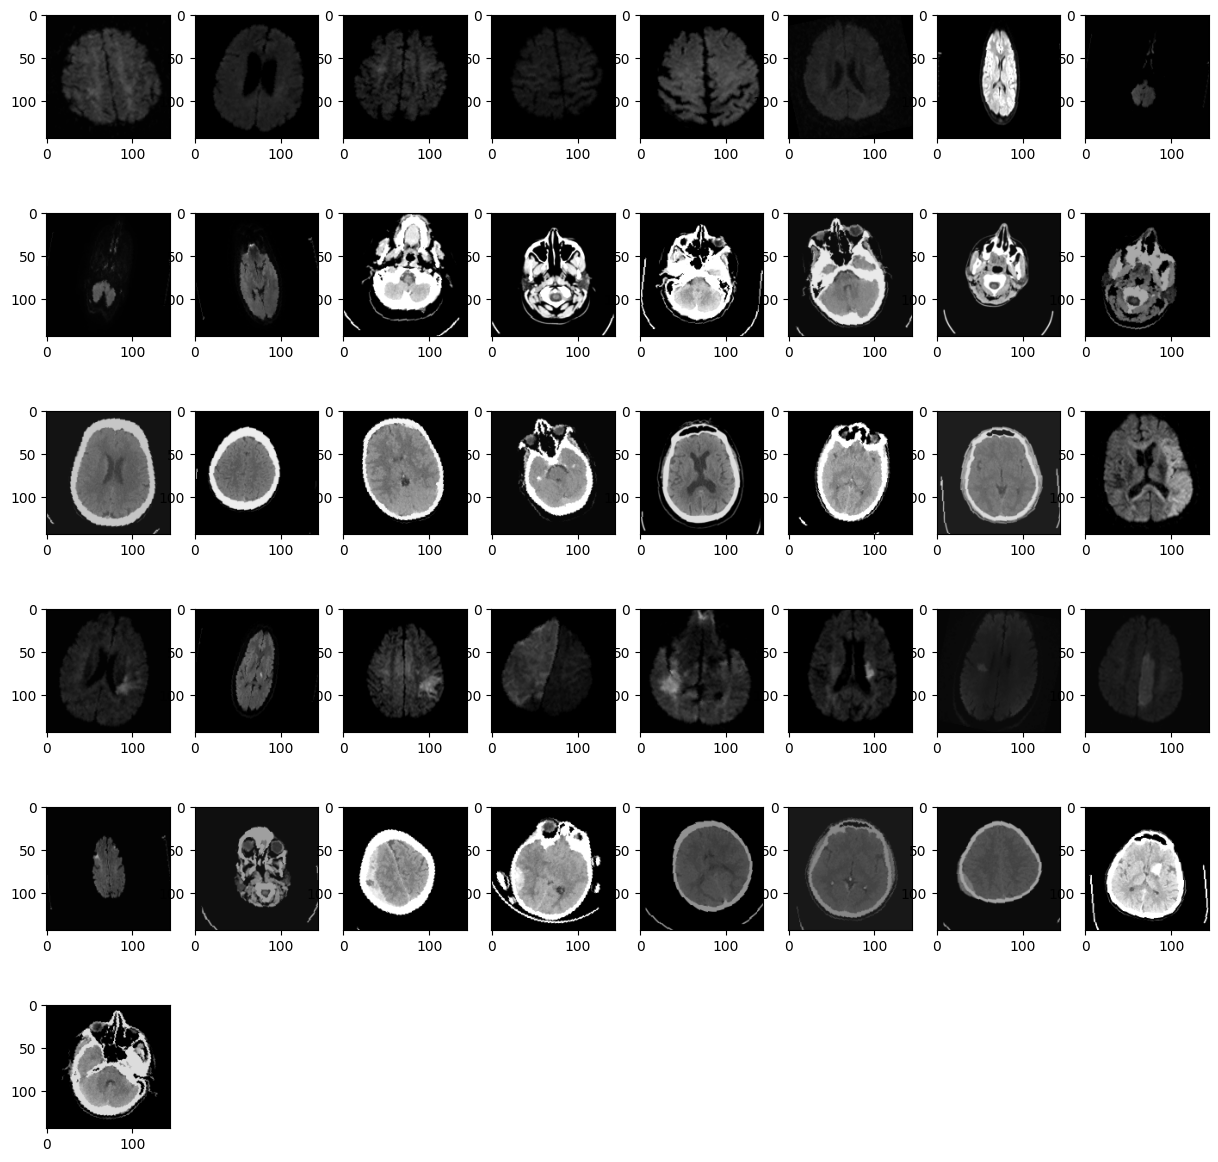

In [1]:
import torch
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, ToTensor, RandomHorizontalFlip, RandomRotation, ColorJitter
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

# Define transformations including data augmentation
augmentations = [
    Resize((144, 144)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    ToTensor()
]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(images) / num_samples)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

nonaugmenteddataset = ImageFolder(root="dataset", transform=Compose(to_tensor))

dataset = ImageFolder(root="dataset", transform=Compose(augmentations))
show_images(dataset)


# Check the size of the dataset
nonaugdataset_size = len(nonaugmenteddataset)
dataset_size = len(dataset)
print(f"The size of the dataset before transformations: {nonaugdataset_size} images")
print(f"The size of the dataset after transformations: {dataset_size} images")


In [2]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [3]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [4]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [5]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [6]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [7]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[ 0.4503, -0.2164,  0.2633, -0.6621, -0.7557, -1.3086,  0.4166,  0.2129,
         -0.5288, -0.6761, -0.6727,  0.4394, -0.2781,  0.3065,  0.5116,  0.9911,
          0.1581,  0.4273,  0.1937, -0.2520, -0.3436, -0.2605, -0.2229, -0.8736,
          0.4252, -0.0446,  0.7628,  0.4783, -0.2196,  0.4006,  0.6172, -0.7527,
          1.0139,  0.2815, -1.0174, -0.3368, -1.5036]],
       grad_fn=<AddmmBackward0>)

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [9]:
import torch.optim as optim
import numpy as np

device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        model.eval()
        with torch.no_grad():
            for step, (inputs, labels) in enumerate(test_dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_losses.append(loss.item())

        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  1.2158834155926035
>>> Epoch 0 test loss:  0.7505028901561615
>>> Epoch 5 train loss:  0.6950655633752997
>>> Epoch 5 test loss:  0.6886944328584979
>>> Epoch 10 train loss:  0.6932557678419696
>>> Epoch 10 test loss:  0.6890361693597609
>>> Epoch 15 train loss:  0.6911184359187922
>>> Epoch 15 test loss:  0.6870669241874449
>>> Epoch 20 train loss:  0.6915878500820192
>>> Epoch 20 test loss:  0.6868957742567985
>>> Epoch 25 train loss:  0.6903966350003707
>>> Epoch 25 test loss:  0.6876750453825919
>>> Epoch 30 train loss:  0.6914714244771595
>>> Epoch 30 test loss:  0.6839524795932155
>>> Epoch 35 train loss:  0.6903820303845997
>>> Epoch 35 test loss:  0.6850157283967541


KeyboardInterrupt: 

In [ ]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)